# Video 4: Lazy expressions using a notebook

#### Step 0: Installation and imports

In [ ]:
!pip install caterva2 blosc2 blosc2_grok matplotlib

In [5]:
import caterva2 as cat2
import blosc2
import numpy as np
import matplotlib.pyplot as plt
from time import time

url = "https://cat2.cloud/demo

#### Step 1: Setup client and get root

In [6]:
client = cat2.Client(url, ('user@example.com', 'foobar11'))
client.get_roots()
myroot = client.get('@personal')
print(myroot)
print(myroot.file_list)

@personal
['a.b2nd', 'b.b2nd', 'c.b2nd', 'le.b2nd', 'le1.b2nd', 'le2.b2nd']


#### Step 2: Create and upload the arrays to the server


In [7]:
N = 1_000
dtype = 'float64'

# Create and upload the arrays to the server
t0 = time()
a = blosc2.linspace(0, 1, N * N, dtype=dtype, shape=(N, N), urlpath="a.b2nd", mode="w")
b = blosc2.linspace(1, 2, N * N, dtype=dtype, shape=(N, N), urlpath="b.b2nd", mode="w")
c = blosc2.linspace(0, 1, N, dtype=dtype, shape=(N,), urlpath="c.b2nd", mode="w")

apath, bpath, cpath = client.upload("a.b2nd", "@personal/a.b2nd"), client.upload("b.b2nd",
                                                                                 "@personal/b.b2nd"), client.upload(
    "c.b2nd", "@personal/c.b2nd")
tarray = time() - t0
fs = (a.schunk.nbytes + b.schunk.nbytes + c.schunk.nbytes)
print(
    f"Time for generating and uploading data (compressed): {tarray:.3f}s"
    f" - data size: {fs / 2 ** 20:.2f} MB"
)

Time for generating and uploading data (compressed): 0.210s - data size: 15.88 MB


In [4]:
ra, rb, rc = client.get(apath), client.get(bpath), client.get(cpath)
print(ra, rb, rc)

<Dataset: @personal/a.b2nd> <Dataset: @personal/b.b2nd> <Dataset: @personal/c.b2nd>


In [6]:
le_path = client.lazyexpr("le2", "a + 1", {"a": apath}, compute=True)

#### Step 3: Send lazy expressions to server

In [6]:
path_le = client.lazyexpr("le", "sin(a) + c", {"a": apath, "c": cpath})
rle = client.get(path_le)
# Compute a slice of the remote array
t0 = time()
result = rle.slice(slice(5, 9))
t1 = time() - t0
fs = result.schunk.nbytes
print(
    f"Time for computing and downloading data (compressed): {t1:.3f}s"
    f" - data size: {fs / 2 ** 10:.2f} KB"
)

# Compute a slice of the remote array
t0 = time()
result = rle[5:9]
t1 = time() - t0
print(
    f"Time for computing and downloading data (uncompressed): {t1:.3f}s"
    f" - data size: {fs / 2 ** 10:.2f} KB"
)

np.allclose((blosc2.sin(a) + c)[5:9], result[:], rtol=1e-6)


Time for computing and downloading data (compressed): 0.238s - data size: 31.25 KB
Time for computing and downloading data (uncompressed): 0.232s - data size: 31.25 KB


True

##### A more complicated expression

In [7]:
path_le = client.lazyexpr("le", "sum(((a**3 + sin(a**2)) < c) & (b > 0), axis = 1)",
                          {"a": apath, "b": bpath, "c": cpath})
rle = client.get(path_le)
# Compute a slice of the remote array
t0 = time()
result = rle.slice(slice(5, 9))
t1 = time() - t0
fs = result.schunk.nbytes
print(
    f"Time for computing and downloading data (compressed): {t1:.3f}s"
    f" - data size: {fs / 2 ** 10:.2f} KB"
)

Time for computing and downloading data (compressed): 0.232s - data size: 7.81 KB


In [8]:
result[:]

array([999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
       999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999, 999,
       999, 999, 999, 999, 999, 999, 998, 998, 998, 998, 998, 998, 998,
       998, 998, 998, 998, 998, 997, 997, 997, 997, 997, 997, 997, 997,
       997, 997, 996, 996, 996, 996, 996, 996, 996, 996, 995, 995, 995,
       995, 995, 995, 995, 994, 994, 994, 994, 994, 994, 993, 993, 993,
       993, 993, 993, 992, 992, 992, 992, 992, 991, 991, 991, 991, 991,
       990, 990, 990, 990, 990, 989, 989, 989, 989, 989, 988, 988, 988,
       988, 987, 987, 987, 987, 986, 986, 986, 986, 985, 985, 985, 984,
       984, 984, 984, 983, 983, 983, 983, 982, 982, 982, 981, 981, 981,
       980, 980, 980, 979, 979, 979, 979, 978, 978, 978, 977, 977, 976,
       976, 976, 975, 975, 975, 974, 974, 974, 973, 973, 973, 972, 972,
       971, 971, 971, 970, 970, 969, 969, 969, 968, 968, 967, 967, 967,
       966, 966, 965, 965, 964, 964, 964, 963, 963, 962, 962, 96

## Bonus: Remote data processing with cat2cloud

<Dataset: @public/examples/lung-jpeg2000_10x.b2nd>
Dataset shape is (10, 1248, 2689) and dtype is uint16


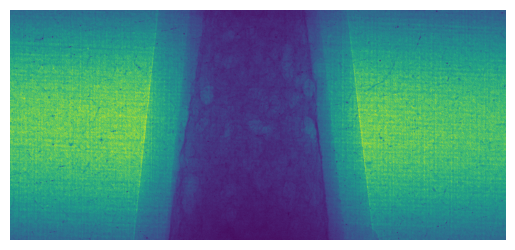

In [12]:
myroot = client.get('@public')
myfile = 'lung-jpeg2000_10x.b2nd'
address = 'examples/' + myfile 
ds = myroot[address]
print(ds)
print(f'Dataset shape is {ds.shape} and dtype is {ds.dtype}')

#Download and decompress slice of dataset
plt.imshow(ds[5][0])
plt.gca().axis('off');

##### Method 1: Download data and compute locally

In [13]:
#Download compressed data and compute std and mean
slice_ = np.index_exp[:, :, :]
t0 = time()
data = ds.slice(slice_)
s = blosc2.std(data, axis=0)
m = blosc2.mean(data, axis=0)
t1 = time() - t0
print(f'std_centre = {s[624, 1345]}, mean_centre = {m[624, 1345]}')
print(f'std_offcentre = {s[20, 20]}, mean_offcentre = {m[20, 20]}')
print(f'Total time = {round(t1, 4)} s')

std_centre = 384.15349015725445, mean_centre = 13373.8
std_offcentre = 6.261309767133161, mean_offcentre = 21535.8
Total time = 2.8967 s


##### Method 2: Upload lazy expression, compute remotely and download result


In [14]:
#Send instructions to server and download std and mean
t0 = time()
std_path = client.lazyexpr('le_std', 'std(a, axis=0)', {'a': ds.path})
mean_path = client.lazyexpr('le_mean', 'mean(a, axis=0)', {'a': ds.path})
s = client.get(std_path).slice(slice_)
m = client.get(mean_path).slice(slice_)
t1 = time() - t0
print(f'std_centre = {s[624, 1345]}, mean_centre = {m[624, 1345]}')
print(f'std_offcentre = {s[20, 20]}, mean_offcentre = {m[20, 20]}')
print(f'Total time = {round(t1, 4)} s')

std_centre = 384.15349015725445, mean_centre = 13373.8
std_offcentre = 6.261309767133161, mean_offcentre = 21535.8
Total time = 3.8678 s


To execute this notebook in a browser running on WSL, run ``jupyter notebook --port=8889 --no-browser`` in the WSL terminal.